In [1]:
import dask.dataframe as dd
from nltk.corpus import stopwords
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from dask.diagnostics import ProgressBar
%matplotlib inline
import seaborn as sns
import ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
from src.utils.helpers_news_movies import *
from src.utils.movies_genres_utils import *
from collections import defaultdict
from scipy.sparse import csr_matrix

# Import code from other files
from src.model import model as m

/Users/antoine/anaconda3/envs/gensim_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Topic modeling  for news

The goal of this part is to test other topic modeling methods to find themes in news papers. We'll test LDA and LSI methods. We'll also try try to find a title for each theme.

In [9]:
# Load stopwords
# nltk.download('stopwords')
# stop_words_ = set(stopwords.words('english'))

In [10]:
ddf = dd.read_parquet('data/nyt_data.parquet')

In [11]:
# Filter dataset for a particular year
filtered_ddf = ddf[(ddf['year'] >= 1968)]

filtered_ddf = filtered_ddf.reset_index(drop=True)

In [12]:
# Combine the text and process it
filtered_ddf['combined_text'] = filtered_ddf['title'] + filtered_ddf['excerpt']
filtered_ddf['processed_text'] = filtered_ddf['combined_text'].apply(preprocess_text, meta=('processed_text', 'str'), args= ('stop_words_',))

## Topic modeling by LDA

In [13]:
# Create the TF matrix
stop_words = stopwords.words('english')
vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words=stop_words, token_pattern=r'\b[a-zA-Z]+\b')

processed_text = filtered_ddf['processed_text'].compute() 
tf_matrix = vectorizer.fit_transform(processed_text)

In [14]:
# Create and fit the model
lda = LatentDirichletAllocation(n_components=30, random_state=0)
lda.fit(tf_matrix)

LatentDirichletAllocation(n_components=30, random_state=0)

In [15]:
# Find and print the terms for each topic
topics_lda = {}
words = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):

    top_words = [words[i] for i in topic.argsort()[-30:]]
    topics_lda[f"Theme {idx+1}"] = top_words

for theme, words in topics_lda.items():
    print(f"{theme}: {' '.join(words)}")

Theme 1: look another near street aboard train even screen father pilot said mother injured yesterday life time people children movie kills death years hurt girl like young crash plane film killed
Theme 2: miller writer submarine author search books graham elizabeth alexander norman russell queen kong hong john frank dead martin illustrated edward review thomas george mary obituary smith york william married dies
Theme 3: seen jerusalem canal cairo urges arabs contract would auto strikes unions wage holds israelis cars rise repts state welfare safety govt labor arab jordan says union workers israeli israel strike
Theme 4: housing ships indus would plans planning maritime ship council assn amer development urges jobs comm project health cities urban help lines says dept study system service plan million city program
Theme 5: olympics france year indians night three london wood winter week field first louis opera last today chess mexico ballet time season games play city world olympic te

## Topic modeling by LSI

In [16]:
# Create the TF-IDF matrix
tf_idf_vectorizer = TfidfVectorizer(max_features=5000)  
tf_idf_matrix = tf_idf_vectorizer.fit_transform(filtered_ddf['processed_text'])

In [17]:
# Create and fit the model
svd_model = TruncatedSVD(n_components=30, random_state=42)
svd_model.fit_transform(tf_idf_matrix)

array([[ 3.76234009e-04,  5.79988863e-02, -7.67179495e-03, ...,
        -5.55559870e-02,  2.79686122e-02, -4.19531684e-02],
       [ 1.38636861e-04,  1.50470607e-02, -2.20691625e-03, ...,
        -4.53609122e-03,  3.73392478e-03,  8.47512817e-04],
       [ 3.31872722e-05,  5.74100379e-03,  3.16885118e-04, ...,
         4.86015780e-04, -3.79888176e-03,  1.75201265e-03],
       ...,
       [ 3.87023220e-04,  5.34929457e-02, -2.89754484e-03, ...,
        -1.85650502e-02, -3.79454851e-02, -7.52958754e-02],
       [ 1.24373123e-04,  2.76736563e-02, -3.92877356e-03, ...,
        -3.92825075e-03, -1.08952268e-02, -3.29337429e-03],
       [ 1.99147662e-04,  2.68113920e-02, -3.98172698e-03, ...,
         3.17849636e-03, -1.86902588e-02, -1.60824652e-02]])

In [18]:
# Find and print the terms for each topic
topics_lsi = {}
terms = tf_idf_vectorizer.get_feature_names_out()
for i, topic in enumerate(svd_model.components_):
    top_terms = [terms[j] for j in topic.argsort()[-20:]]
    topics_lsi[f"Topic {i+1}"] = top_terms

for topic, terms in topics_lsi.items():
    print(f"{topic}: {' '.join(terms)}")

Topic 1: that illus from wins with today birth notice review marriage announcement letter editor editorial cartoon front page obituary article title
Topic 2: more their york humphrey after vietnam nixon state have million pres over today johnson city says from that will with
Topic 3: david james nancy affianced fiancee mary marry susan robert prospective weds fiance john nuptials betrothed becomes engaged married bride miss
Topic 4: killed senators reston miss identified servicemen week capital states united treasury department following casualties vietnam court supreme today washington proceedings
Topic 5: game announcement victory with engaged marriage first york letter editor today editorial cartoon married wins miss front page title obituary
Topic 6: chief vice exec letter editor john elects president editorial pres prospective cartoon named elected becomes front page title obituary bride
Topic 7: title post nixon head executive humphrey married johnson names obituary chmn miss chi

We tried to find topics for the year 1968. It seems to work since we recognized some hot topics of society from this year, such as the Vietnam war or students' protests.

## Find title for topic

In [22]:
# Load a model already trained to encode words
model = KeyedVectors.load_word2vec_format("data/word2vec.bin", binary=True)

In [23]:
# Find a word that summarizes the themes found above
def find_theme(list_words, model):
    vectors = []
    # Calculate the average vector for the theme
    for w in list_words:
        if w in model:
            vectors.append(model[w])
    if vectors:
        avg_vec = sum(vectors) / len(vectors)
    else:
        avg_vec = None
        
    # Find the closest word
    closest_words = model.most_similar(positive=[avg_vec], topn=1)

    closest_w, sim_max = closest_words[0] 
    return closest_w

In [25]:
# Print the topics found
for t, ws in topics_lsi.items():
    print(t)
    print(f"Terms {ws}")
    theme = find_theme(ws, model)
    print(f"Theme word : {theme}")

Topic 1
Terms ['that', 'illus', 'from', 'wins', 'with', 'today', 'birth', 'notice', 'review', 'marriage', 'announcement', 'letter', 'editor', 'editorial', 'cartoon', 'front', 'page', 'obituary', 'article', 'title']
Theme word : obituary
Topic 2
Terms ['more', 'their', 'york', 'humphrey', 'after', 'vietnam', 'nixon', 'state', 'have', 'million', 'pres', 'over', 'today', 'johnson', 'city', 'says', 'from', 'that', 'will', 'with']
Theme word : city
Topic 3
Terms ['david', 'james', 'nancy', 'affianced', 'fiancee', 'mary', 'marry', 'susan', 'robert', 'prospective', 'weds', 'fiance', 'john', 'nuptials', 'betrothed', 'becomes', 'engaged', 'married', 'bride', 'miss']
Theme word : marry
Topic 4
Terms ['killed', 'senators', 'reston', 'miss', 'identified', 'servicemen', 'week', 'capital', 'states', 'united', 'treasury', 'department', 'following', 'casualties', 'vietnam', 'court', 'supreme', 'today', 'washington', 'proceedings']
Theme word : soldiers
Topic 5
Terms ['game', 'announcement', 'victory',

The results are coherent but do not seem sufficient for further analysis. We will maybe have to find n-grams to better define the themes or do it manually.

## Compare Topics in News and in Movies

This part shows an example of how we could explore similarities in societal issues between news articles and movies plots. Once we have our topics of interests, we can do semantic search with a sentence-transformer model and compare their presence over time. We will also do more advanced statistical analysis, which we haven't done yet in this part.

## Load NYT dataset

In [26]:
# Select a time period and compute
with ProgressBar():
    filtered_ddf = ddf[(ddf['year'] >= 1950) & (ddf['year'] <= 2000)].compute()

filtered_ddf = dd.from_pandas(filtered_ddf, npartitions=100)

# Select only a tiny fraction because the data is too large and a small percentage is sufficient for our analyses
filtered_ddf = filtered_ddf.sample(frac=0.01, random_state=42).reset_index(drop=True)


[########################################] | 100% Completed | 6.43 ss


In [27]:
# Create a combined text field for further analysis
filtered_ddf['combined_text'] = filtered_ddf['title'] + filtered_ddf['excerpt']

In [28]:
df_movies = pd.read_csv('data/MovieSummaries/movies_metadata_cleaned.csv')

In [29]:
df_movies.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Decade,Movie_continent,Grouped_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",2000.0,North America,"['Science Fiction', 'Thriller', 'Action/Advent..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,['English Language'],['United States of America'],"['Mystery', 'Biographical film', 'Drama', 'Cri...",2000.0,North America,"['Biography', 'Drama', 'Mystery']"
2,28463795,/m/0crgdbh,Brun bitter,1988.0,NaN,83.0,['Norwegian Language'],['Norway'],"['Crime Fiction', 'Drama']",1980.0,Europe,"['Drama', 'Fiction']"
3,9363483,/m/0285_cd,White Of The Eye,1987.0,NaN,110.0,['English Language'],['United Kingdom'],"['Thriller', 'Erotic thriller', 'Psychological...",1980.0,Europe,['Thriller']
4,261236,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,['German Language'],['Germany'],['Drama'],1980.0,Europe,['Drama']


In [30]:
# Select period of time
start_date = 1950
end_date = 2000

df_movies = df_movies[(df_movies['Movie_release_date'] >= start_date) & (df_movies['Movie_release_date'] < end_date)]

In [31]:
# Create lists
ids = df_movies["Wikipedia_movie_ID"].to_list()
movies_dict = load_plot_summaries("data/MovieSummaries/plot_summaries.txt")
movies_dict = {k: movies_dict[k] for k in movies_dict if k in ids}
movie_descriptions = list(movies_dict.values())
movie_ids = list(movies_dict.keys())

## Launch Model for movies topic 1

We use a model from sentence-transformers to do semantic search. We will try the methods for 2 different topics.

In [32]:
# Load the model
model_miniLM = SentenceTransformer("all-MiniLM-L6-v2")

In [33]:
# Encode the query
query_embedding = model_miniLM.encode(["women's rights"])

In [34]:
# Encode the movie descriptions
movie_embeddings = model_miniLM.encode(movie_descriptions, batch_size=64)

In [35]:
# Calculate similarity with the query
similarities = cosine_similarity(query_embedding, movie_embeddings).flatten()
ids = [movie_ids[i] for i, sim in enumerate(similarities) if sim > 0.2]

In [36]:
df_movies_new = df_movies[df_movies['Wikipedia_movie_ID'].isin(ids)]
df_movies_new.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Decade,Movie_continent,Grouped_genres
4,261236,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,['German Language'],['Germany'],['Drama'],1980.0,Europe,['Drama']
163,9169526,/m/027_08f,Las Boludas,1993.0,NaN,NaN,['Spanish Language'],['Argentina'],['Comedy'],1990.0,South America,['Comedy']
214,2316181,/m/07385y,El derecho de nacer,1951.0,NaN,110.0,['Spanish Language'],['Mexico'],"['Drama', 'World cinema']",1950.0,North America,"['World', 'Drama']"
220,20119316,/m/04yfw36,Eoudong,1985.0,NaN,110.0,[],['South Korea'],['Drama'],1980.0,Asia,['Drama']
228,30173306,/m/0g59khw,Ab Insaf Hoga,1995.0,NaN,125.0,['Hindi Language'],[],['Drama'],1990.0,Unknown,['Drama']


## Launch model for news topic 1

In [37]:
# Encode the text
with ProgressBar():
    news = filtered_ddf['combined_text'].compute().tolist()  # Utilisation de compute() pour Dask
news_embeddings = model_miniLM.encode(news, batch_size=64)

[########################################] | 100% Completed | 320.52 ms


In [38]:
filtered_ddf_pandas = filtered_ddf.compute()

In [39]:
# Calculate similarity with the query
similarities = cosine_similarity(query_embedding, news_embeddings).flatten()
similar_entries_indices = np.where(similarities >= 0.3)[0]
filtered_similar_ddf = filtered_ddf_pandas.iloc[similar_entries_indices].reset_index(drop=True)

## Plot evolution

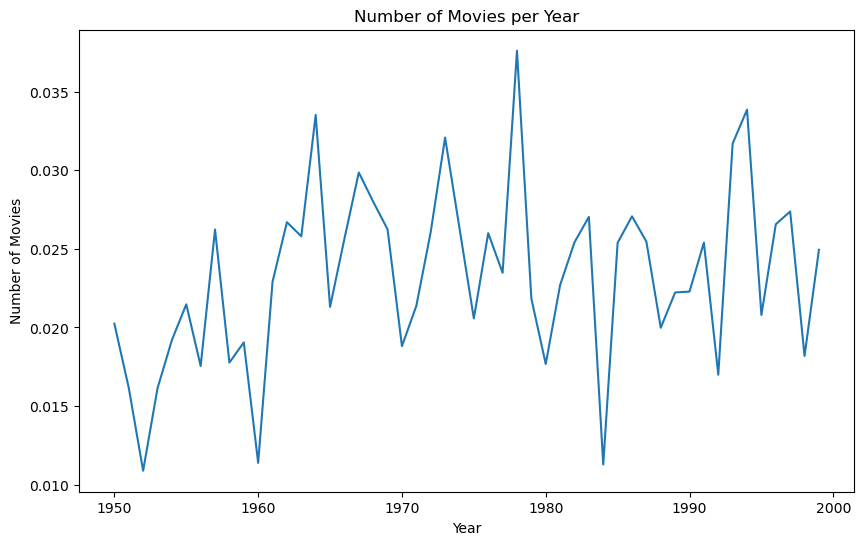

In [40]:
# Calculate the relative presence of the topic across the years
count_per_year = df_movies_new.groupby('Movie_release_date').size()
total_count_per_year = df_movies.groupby('Movie_release_date').size()

relative_count_per_year = count_per_year / total_count_per_year

# Create the line plot
relative_count_per_year.plot(kind='line', figsize=(10, 6), title="Number of Movies per Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.show()


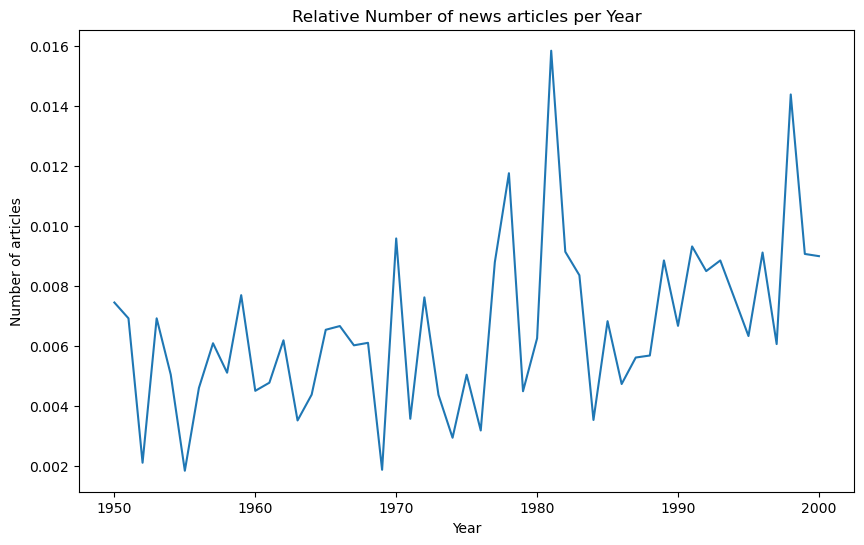

In [41]:
# Calculate the relative presence of the topic accross the years
count_per_year_similar = filtered_similar_ddf.groupby('year').size()
total_count_per_year_similar = filtered_ddf_pandas.groupby('year').size()

relative_count_per_year_similar = count_per_year_similar / total_count_per_year_similar

relative_count_per_year_similar = relative_count_per_year_similar.dropna()

# Line plot
relative_count_per_year_similar.plot(kind='line', figsize=(10, 6), title="Relative Number of news articles per Year")
plt.xlabel("Year")
plt.ylabel("Number of articles")
plt.show()

The tendencies need to be examined in details to draw conclusions. At first glance, we see that there is no particular tendency for women's rights presence in movies while in news articles it tends to increase.

## Launch model for news topic 2

In [42]:
# Calculate similarity for the new topic
query_embedding_env = model_miniLM.encode(["environmental issues"])

similarities_env = cosine_similarity(query_embedding_env, movie_embeddings).flatten()
ids_env = [movie_ids[i] for i, sim in enumerate(similarities_env) if sim > 0.2]

df_movies_new_env = df_movies[df_movies['Wikipedia_movie_ID'].isin(ids_env)]
df_movies_new_env

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Decade,Movie_continent,Grouped_genres
49,261237,/m/01mrrd,The Gods Must Be Crazy,1980.0,34331783.0,109.0,"['Afrikaans Language', 'English Language']",['South Africa'],"['Adventure', 'Action/Adventure', 'Indie', 'Wo...",1980.0,Africa,"['Slapstick', 'Cult', 'Action/Adventure', 'Ind..."
112,2154704,/m/06qv1c,Choke Canyon,1986.0,NaN,94.0,['English Language'],['United States of America'],"['Thriller', 'Action Thrillers', 'Science Fict...",1980.0,North America,"['Action/Adventure', 'Science Fiction', 'Thril..."
560,2524925,/m/07kwyt,The Land Before Time III: The Time of the Grea...,1995.0,NaN,71.0,['English Language'],['United States of America'],"['Adventure', ""Children's/Family"", 'Animation'...",1990.0,North America,"['Action/Adventure', 'Family', 'Animation', 'M..."
887,19160892,/m/04lghfb,No Kidding,1960.0,NaN,83.0,['English Language'],['United Kingdom'],['Comedy'],1960.0,Europe,['Comedy']
1907,5493659,/m/0dp8qk,Slugs,1988.0,NaN,90.0,"['English Language', 'Spanish Language']","['United States of America', 'Spain']","['Natural horror films', 'Science Fiction', 'H...",1980.0,North America,"['Science Fiction', 'Horror', 'World', 'Creatu..."
...,...,...,...,...,...,...,...,...,...,...,...,...
78390,21450904,/m/05fbncw,Bug Buster,1998.0,NaN,93.0,['English Language'],['United States of America'],"['Parody', 'Science Fiction', 'B-movie', 'Come...",1990.0,North America,"['Science Fiction', 'Action/Adventure', 'Horro..."
79241,8960083,/m/027r9jf,Megaville,1990.0,NaN,93.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Indie', 'Myst...",1990.0,North America,"['Dystopia', 'Science Fiction', 'Thriller', 'A..."
79942,10696616,/m/02qmjbc,The Stars Fell on Henrietta,1995.0,NaN,109.0,['English Language'],['United States of America'],"['Americana', 'Drama']",1990.0,North America,"['Americana', 'Drama']"
81321,25875124,/m/0bysdr9,It’s a Long Way to the Sea,1995.0,NaN,106.0,['Assamese Language'],['India'],['Drama'],1990.0,Asia,['Drama']


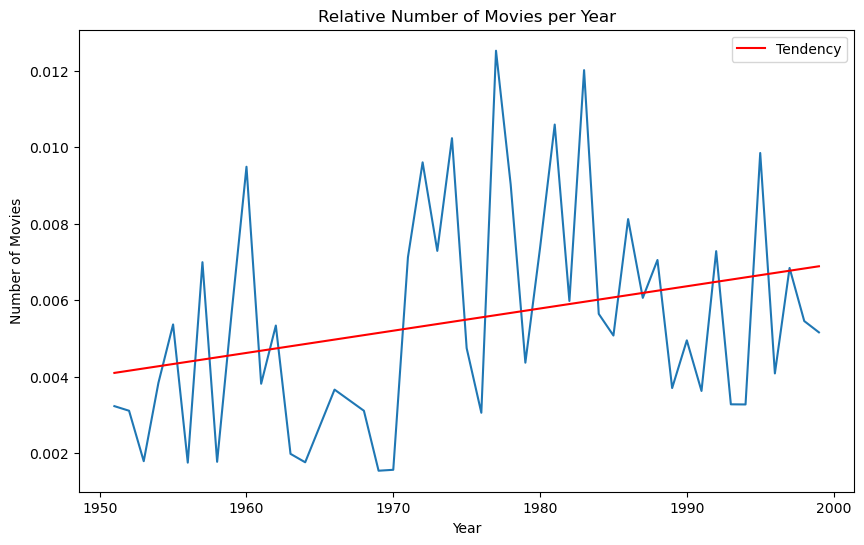

In [43]:
# Calculate the relative presence of the topic accross the years
count_per_year = df_movies_new_env.groupby('Movie_release_date').size()

total_count_per_year = df_movies.groupby('Movie_release_date').size()

relative_count_per_year = count_per_year / total_count_per_year

relative_count_per_year = relative_count_per_year.dropna()

# Create the line plot
relative_count_per_year.plot(kind='line', figsize=(10, 6), title="Relative Number of Movies per Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")

# Generate a linear regression line to the data
x = relative_count_per_year.index.astype(int)  # Ensure 'Year' is in integer format
y = relative_count_per_year.values
a, b = np.polyfit(x, y, 1)  # 1 indicates a linear fit (degree 1 polynomial)

regression_line = a * x + b

plt.plot(x, regression_line, color='red', label='Tendency')
plt.legend()

plt.show()

In [44]:
# Calculate similarity with new query
similarities_env_news = cosine_similarity(query_embedding_env, news_embeddings).flatten()
similar_entries_indices_env_news = np.where(similarities_env_news >= 0.4)[0]
filtered_similar_ddf_env_news = filtered_ddf_pandas.iloc[similar_entries_indices_env_news].reset_index(drop=True)

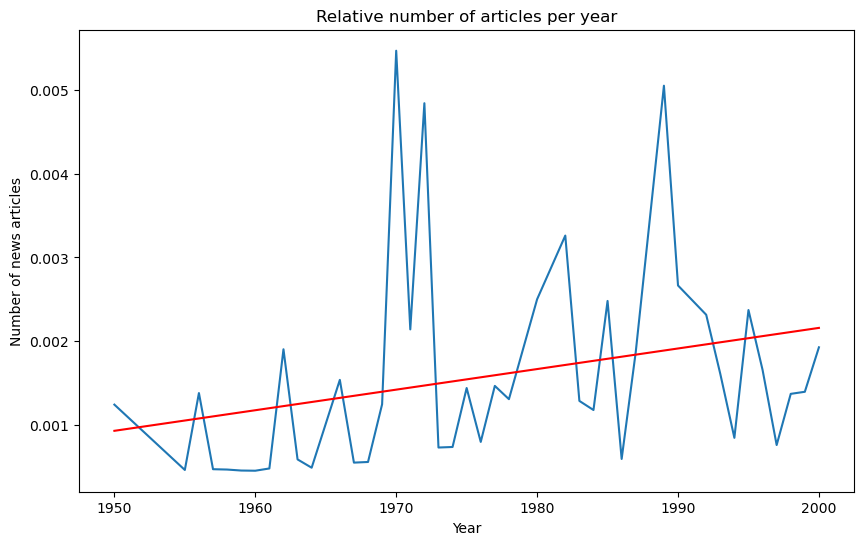

In [45]:
# Calculate the relative presence of the topic accross the years
count_per_year_similar = filtered_similar_ddf_env_news.groupby('year').size()

relative_count_per_year_similar = count_per_year_similar / total_count_per_year_similar

relative_count_per_year_similar = relative_count_per_year_similar.dropna()

# Create a line plot
relative_count_per_year_similar.plot(kind='line', figsize=(10, 6), title="Relative number of articles per year")
plt.xlabel("Year")
plt.ylabel("Number of news articles")

# Generate a linear regression line to the data
x = relative_count_per_year_similar.index.astype(int)  
y = relative_count_per_year_similar.values
a, b = np.polyfit(x, y, 1) 

regression_line = a * x + b

plt.plot(x, regression_line, color='red', label='Tendency')

plt.show()

In this case, we observe that the relative presence of "environmental issues" tends to increase over time. We would need more in-depth analysis to draw conclusions.

# Initial results about movies dataset

In [46]:
# Load preprocessed data
data_folder = 'data/MovieSummaries/'
df_metadata = pd.read_csv(data_folder + 'movies_metadata_cleaned.csv')

df_metadata

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Decade,Movie_continent,Grouped_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",2000.0,North America,"['Science Fiction', 'Thriller', 'Action/Advent..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,['English Language'],['United States of America'],"['Mystery', 'Biographical film', 'Drama', 'Cri...",2000.0,North America,"['Biography', 'Drama', 'Mystery']"
2,28463795,/m/0crgdbh,Brun bitter,1988.0,NaN,83.0,['Norwegian Language'],['Norway'],"['Crime Fiction', 'Drama']",1980.0,Europe,"['Drama', 'Fiction']"
3,9363483,/m/0285_cd,White Of The Eye,1987.0,NaN,110.0,['English Language'],['United Kingdom'],"['Thriller', 'Erotic thriller', 'Psychological...",1980.0,Europe,['Thriller']
4,261236,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,['German Language'],['Germany'],['Drama'],1980.0,Europe,['Drama']
...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011.0,NaN,120.0,['English Language'],['United States of America'],['Drama'],2010.0,North America,['Drama']
81737,34980460,/m/0g4pl34,Knuckle,2011.0,NaN,96.0,['English Language'],"['Ireland', 'United Kingdom']","['Biographical film', 'Drama', 'Documentary']",2010.0,Europe,"['Biography', 'Drama', 'Documentary']"
81738,9971909,/m/02pygw1,Another Nice Mess,1972.0,NaN,66.0,['English Language'],['United States of America'],"['Satire', 'Comedy']",1970.0,North America,"['Comedy', 'Satire']"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992.0,NaN,150.0,['Japanese Language'],['Japan'],"['Science Fiction', 'Japanese Movies', 'Advent...",1990.0,Asia,"['Science Fiction', 'Short Film', 'Japanese Mo..."


In [47]:
# Identify NaNs in the 'Grouped_genres' and remove them
problematic_values = []
for index, value in df_metadata['Grouped_genres'].items(): 
    if isinstance(value, str):
        try:
            ast.literal_eval(value)
        except (ValueError, SyntaxError):
            problematic_values.append((index, value))

            
df_metadata = df_metadata.drop([index for index, _ in problematic_values])

## Analysis of genres across the world throughout the decades

In [48]:
# Count of Genres per decade

# Expand the genres
df_metadata['Grouped_genres'] = df_metadata['Grouped_genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_expanded = df_metadata.explode('Grouped_genres')

# Group by 'Decade' and 'Movie_genres' and count occurrences
genre_distribution = df_expanded.groupby(['Decade', 'Grouped_genres']).size().reset_index(name="Count")

# Sort 'Decade' and 'Count' in descending order
genre_distribution = genre_distribution.sort_values(by=['Decade', 'Count'], ascending=[True, False])

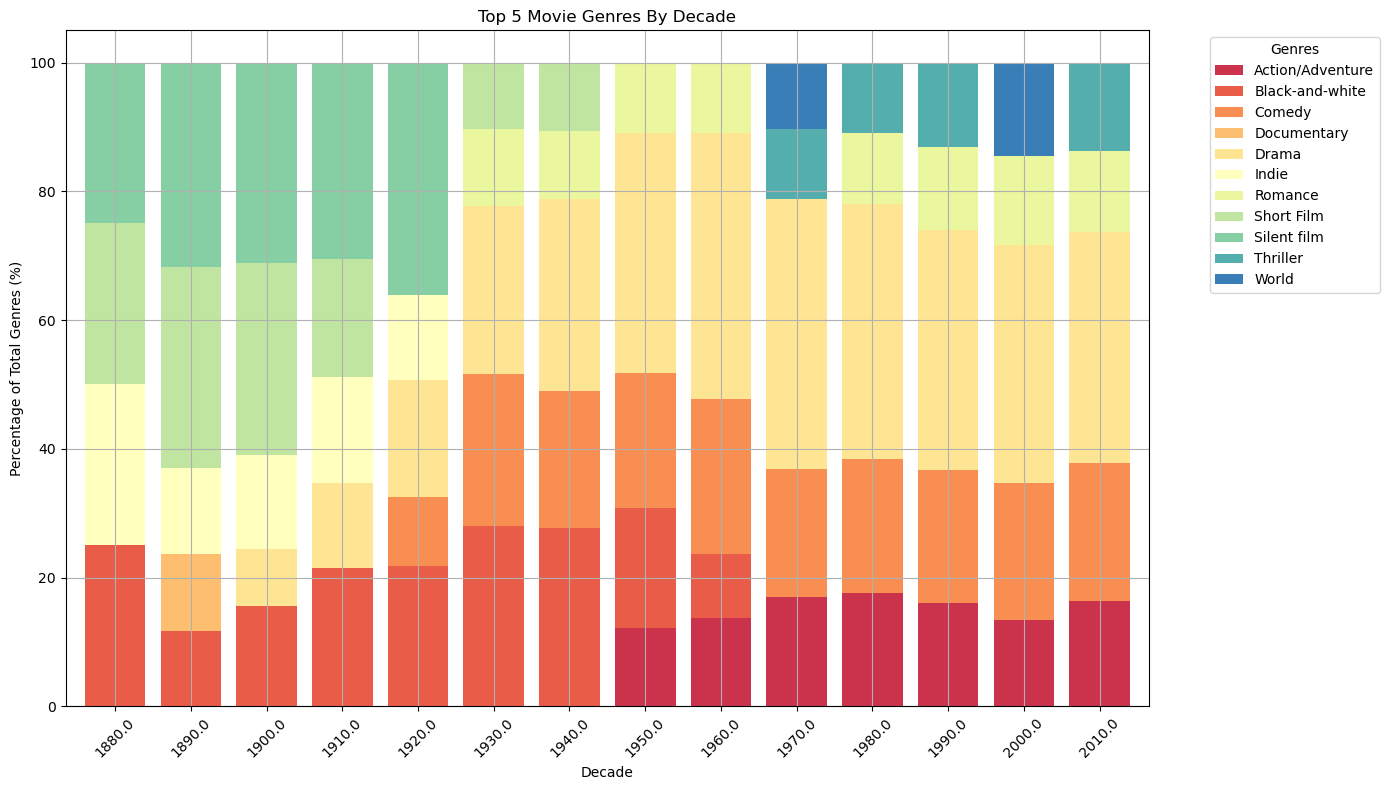

In [49]:
plot_top_genres(5, genre_distribution)

### Observations

We can observe the evolution of movie genres across the decades. Some genres, like Silent Films, disappeared from the top 5, while others emerged over time. Certain genres, such as Romance and Action/Adventure, were prominent in most decades but less so in others.

Drama and Comedy, however, were consistently dominant across most decades. 

The World genre stood out in three specific decades: the 1960s, 1970s, and 2000s. Its prominence in the first two may be attributed to the Cold War, while in the 2000s, it could be due to globalization.

We can also observe the emergence of Action/Adventure during 1960 and Thriller during 1970.

In [50]:
all_genre_distr = df_expanded.groupby(['Grouped_genres']).size().reset_index(name="Count")
all_genre_distr = all_genre_distr.sort_values(by=['Count'], ascending=False)

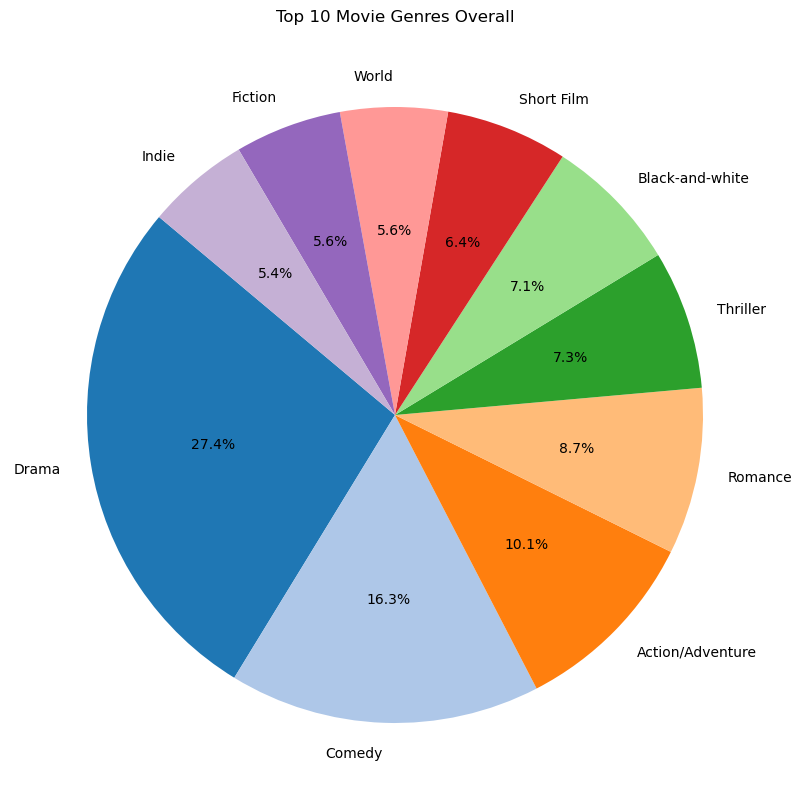

In [51]:
plot_top_genres_overall(10, all_genre_distr)

### Observations

We see that the two prevalent genres are Drama and Comedy, which supports our previous observations.

## Analysis of movies genres throughout the decades by continent

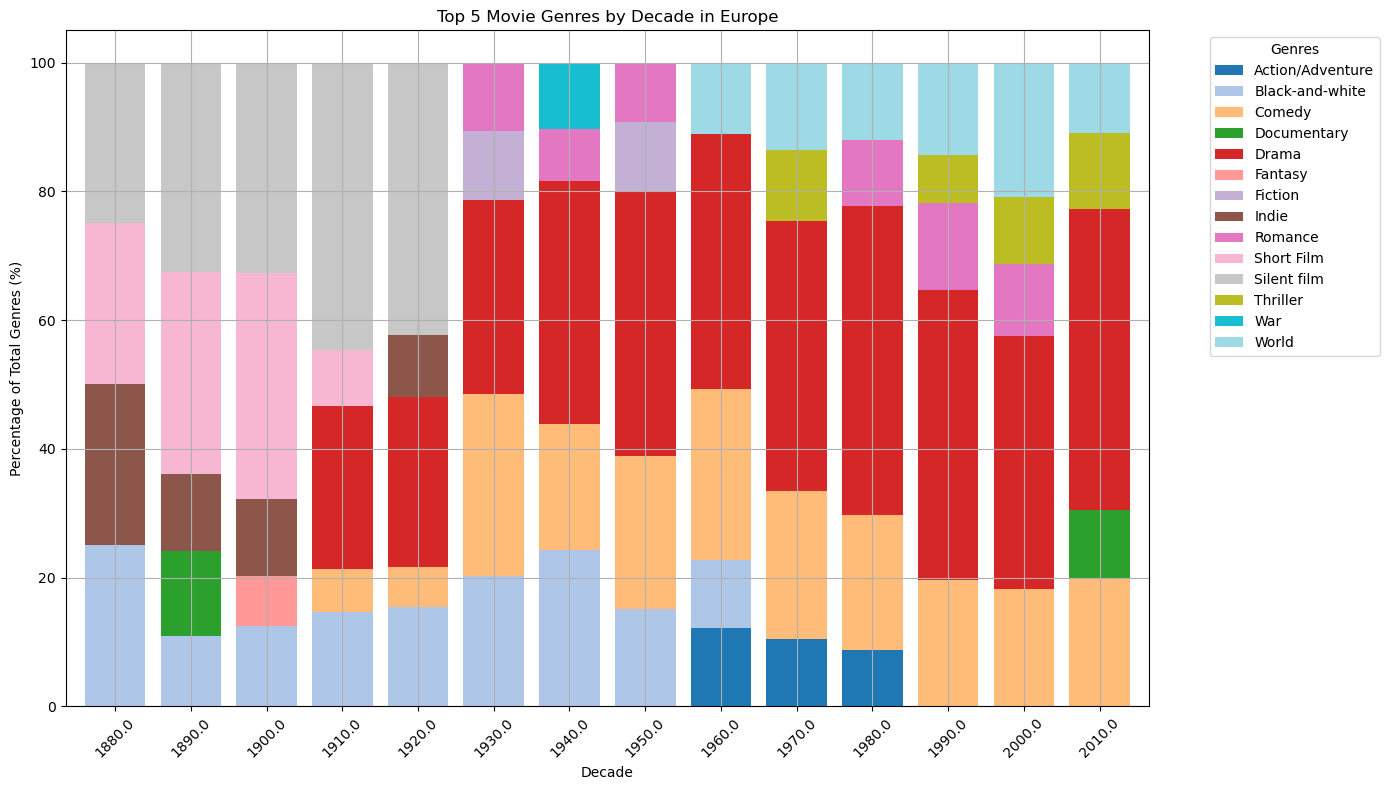

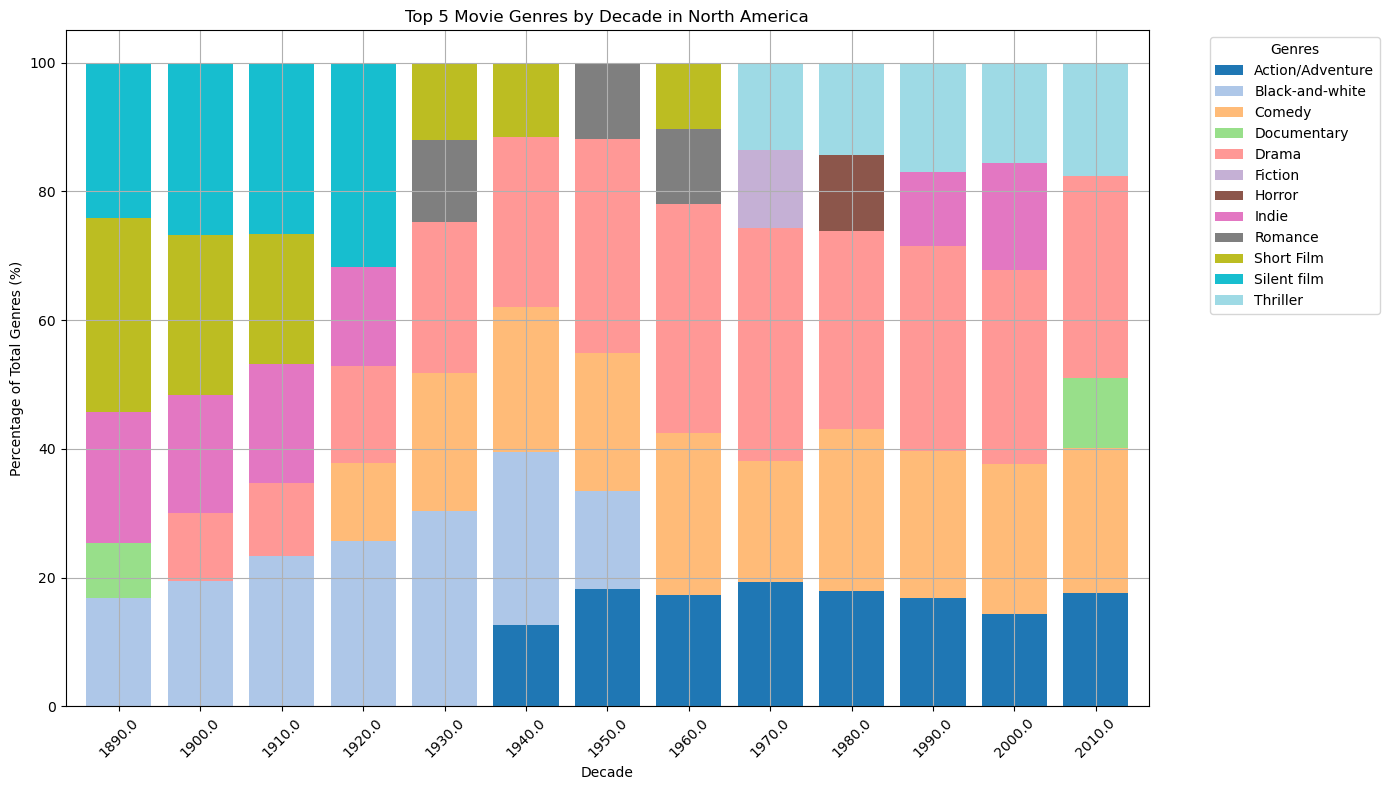

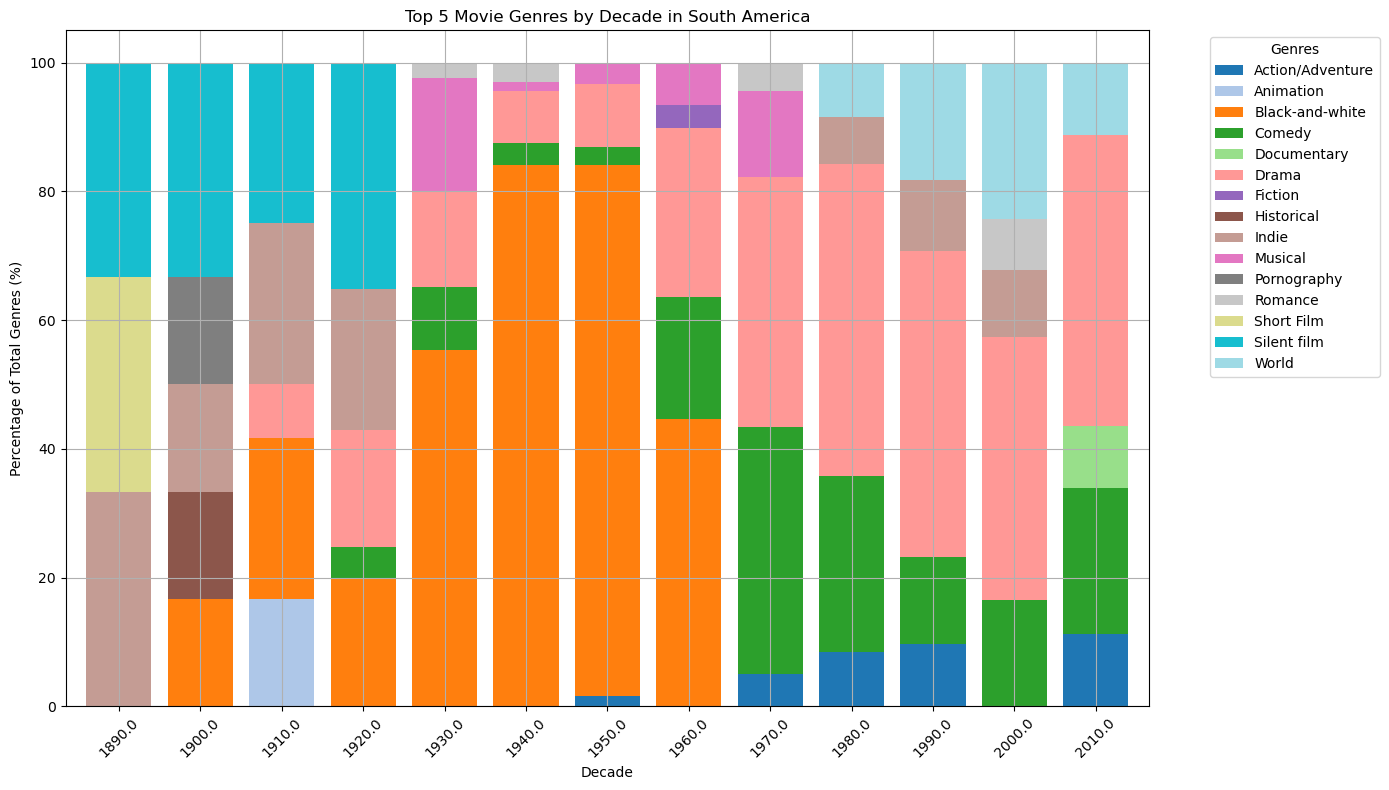

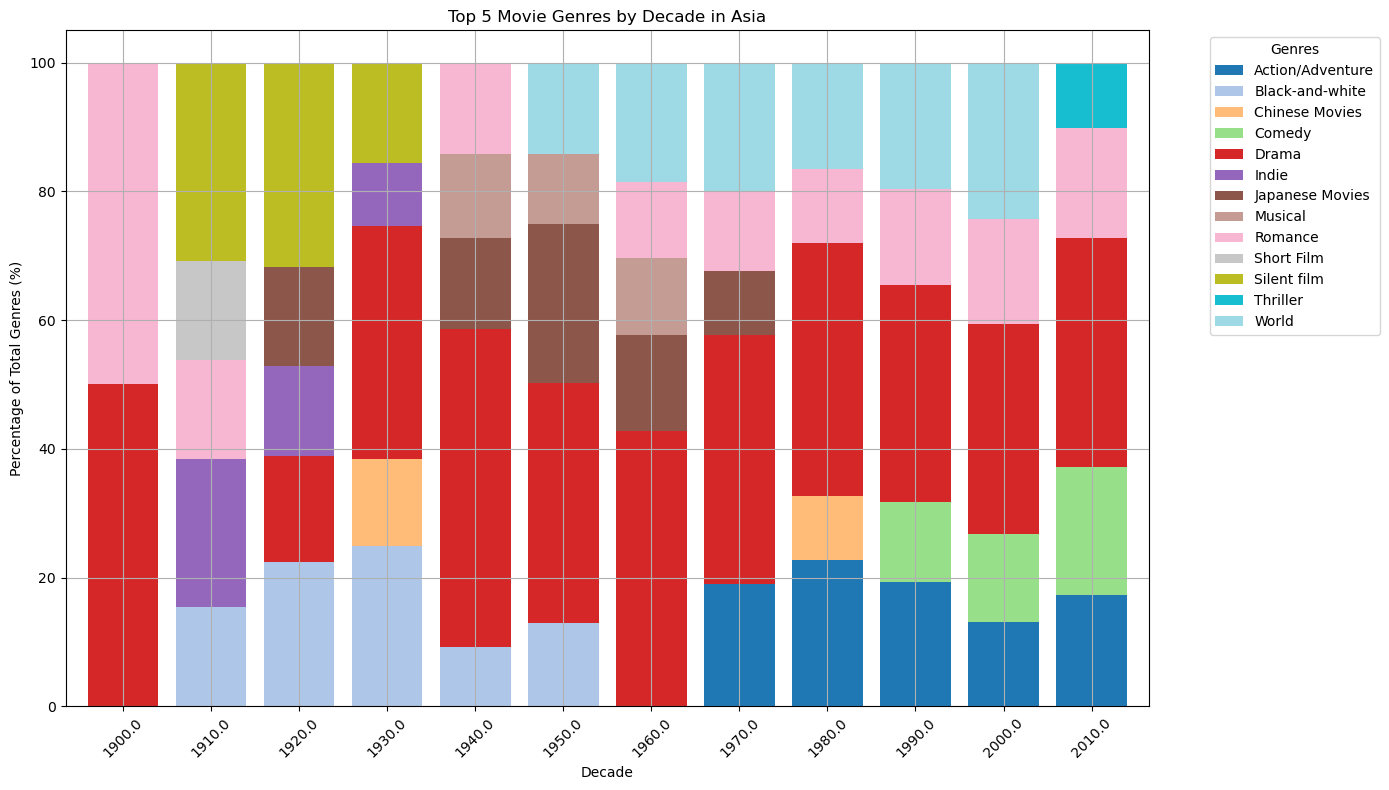

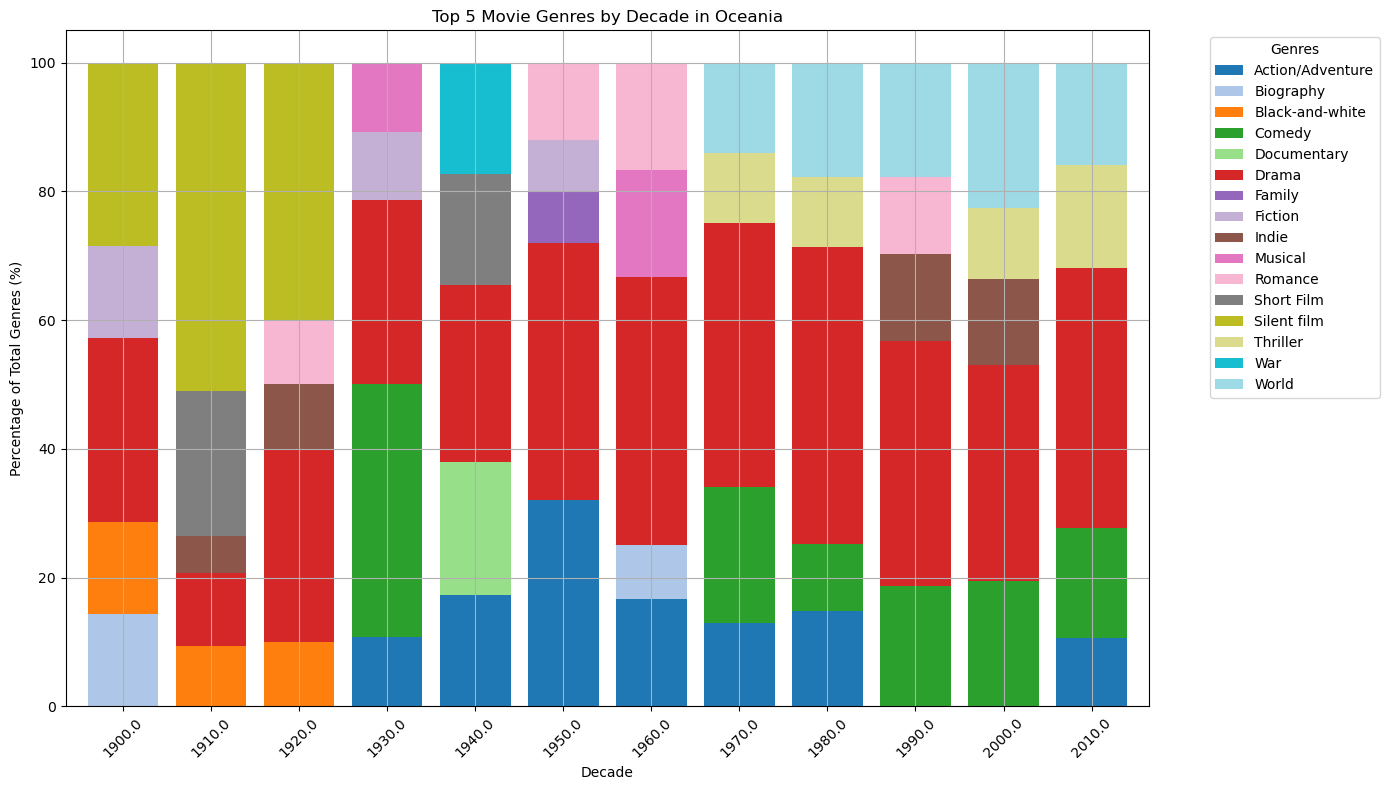

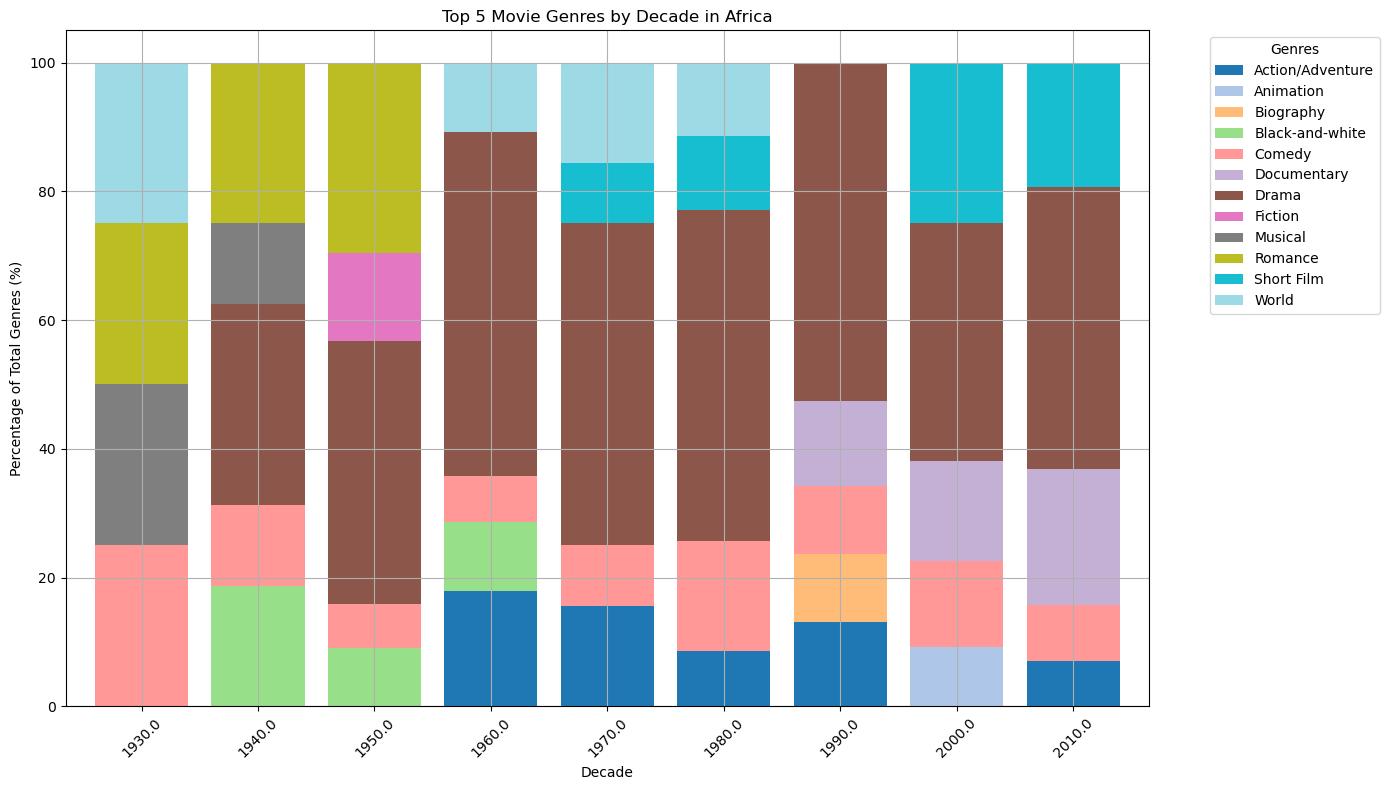

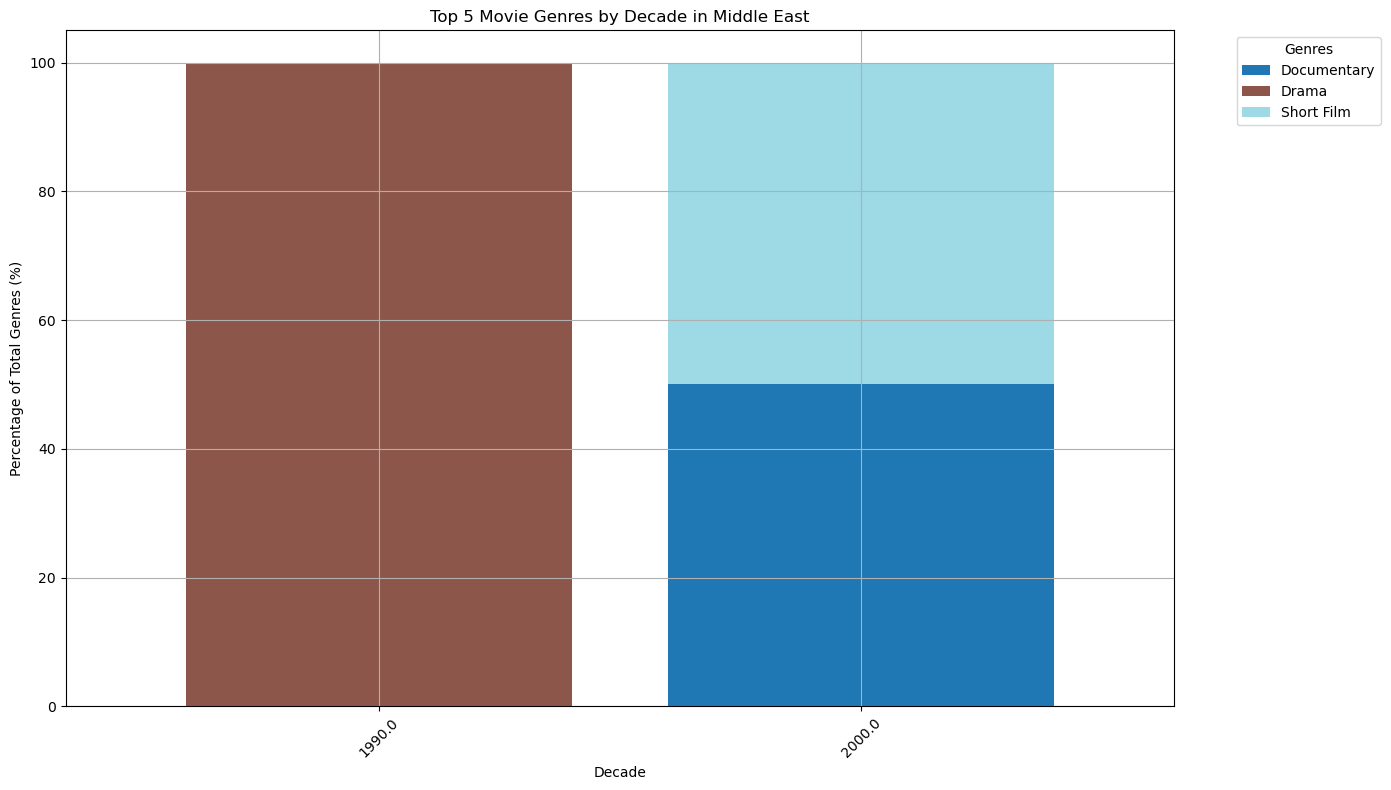

In [52]:
# Top 5 genres in each continent for each decade
plot_top_genres_by_continent(df_expanded)

### Observations

Drama is, as expected, the most prevalent genre across each continent. Surprisingly, the Middle East shows only two genres—Short Film and Documentary—in the 2000s, suggesting a limited representation of Middle Eastern films in the dataset.

The appearance of War as a genre in Europe and Oceania during the 1940s correlates with World War II, reflecting how cinema often mirrors historical events during major conflicts.

In North America, the last seven decades show a stable composition of Action/Adventure, Comedy, and Drama, with a touch of Thriller, suggesting a stable trend in popular genres.

Interestingly, in Africa, the most common genres in the recent decade are Documentary and Short Film. This may show a focus on real-life stories on Africa that may resonate with African Audiences.

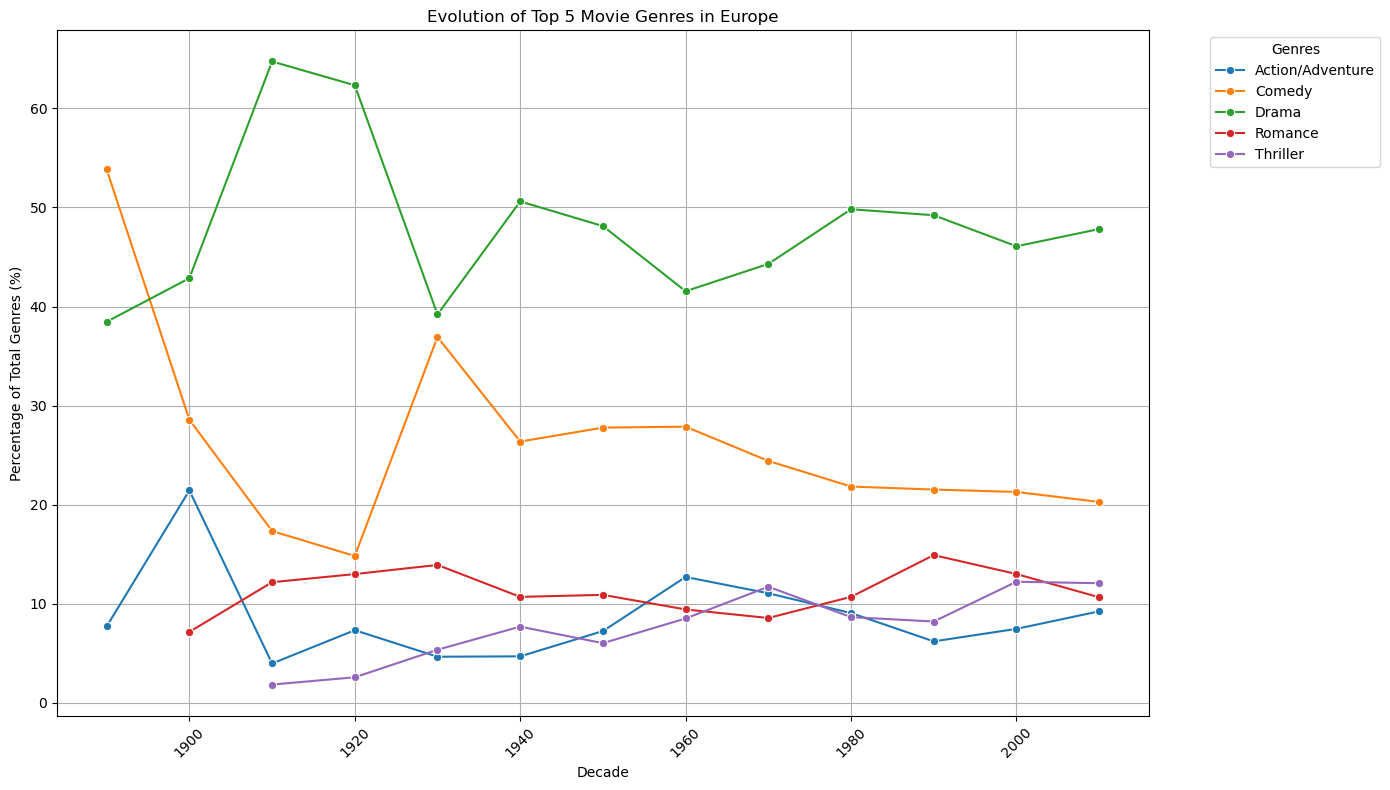

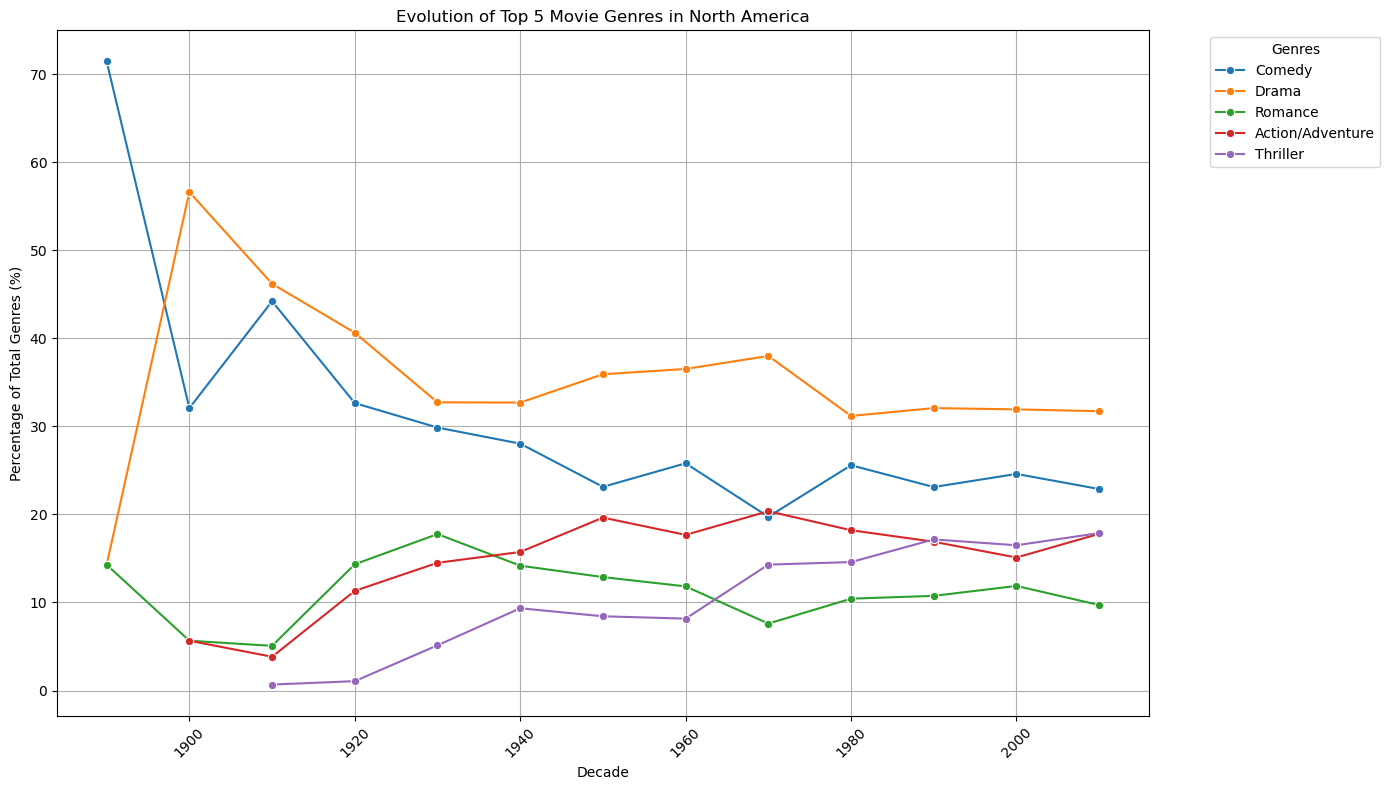

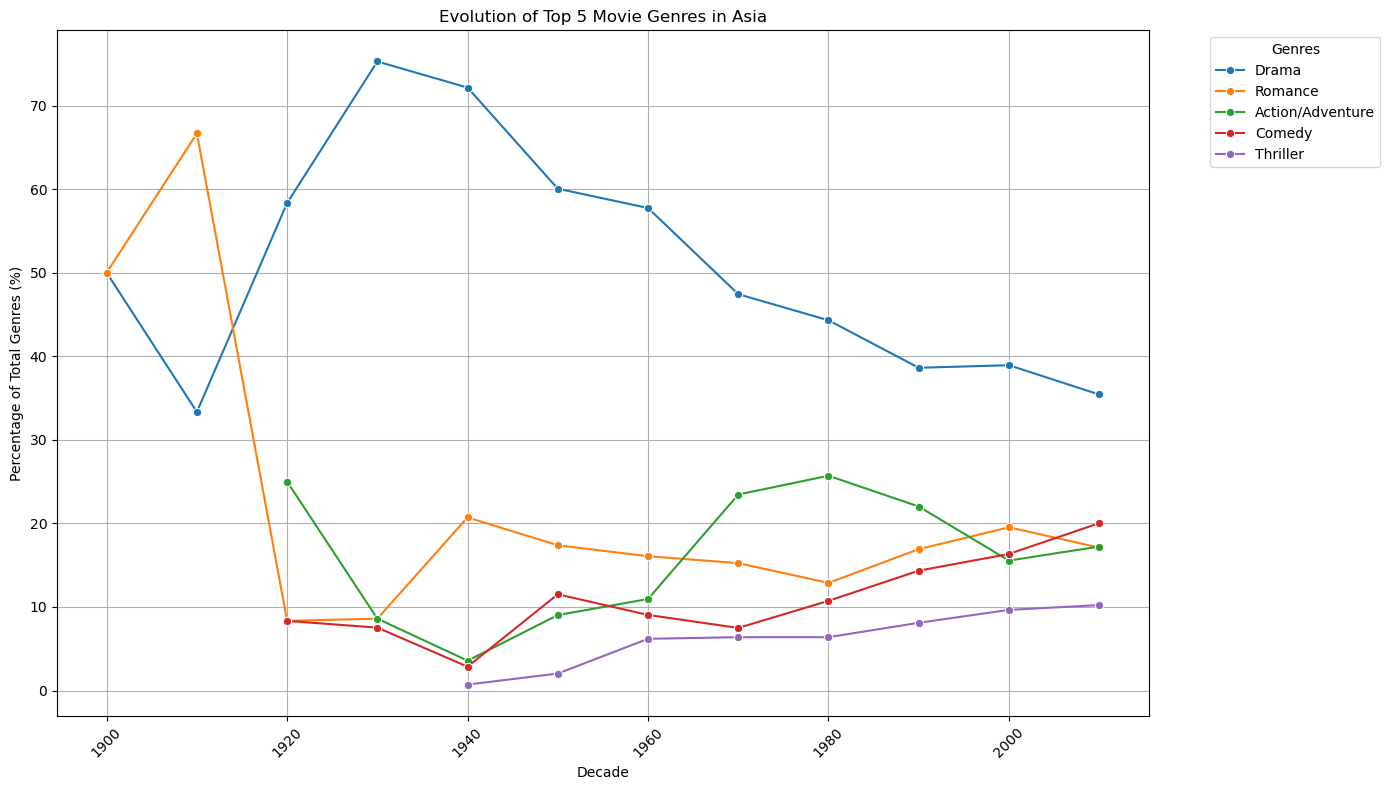

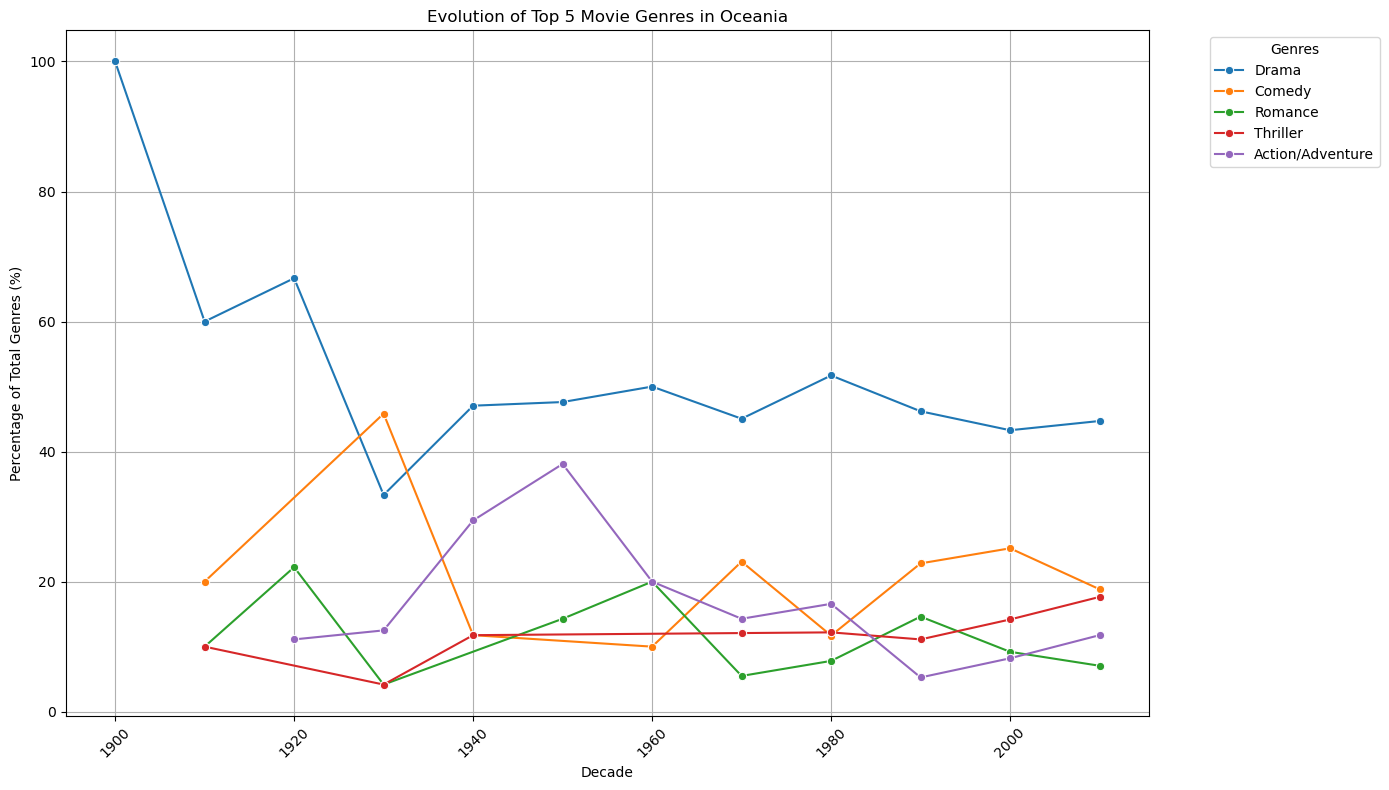

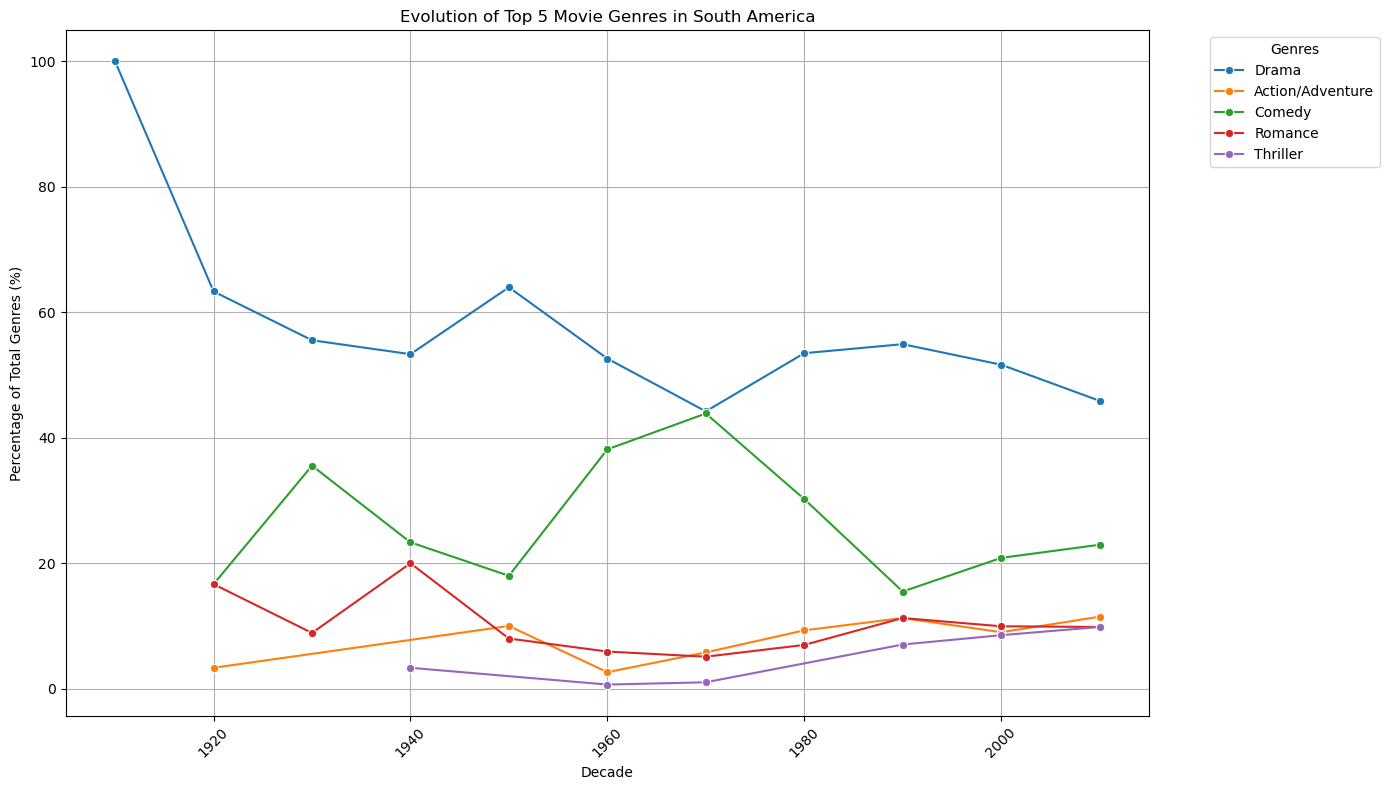

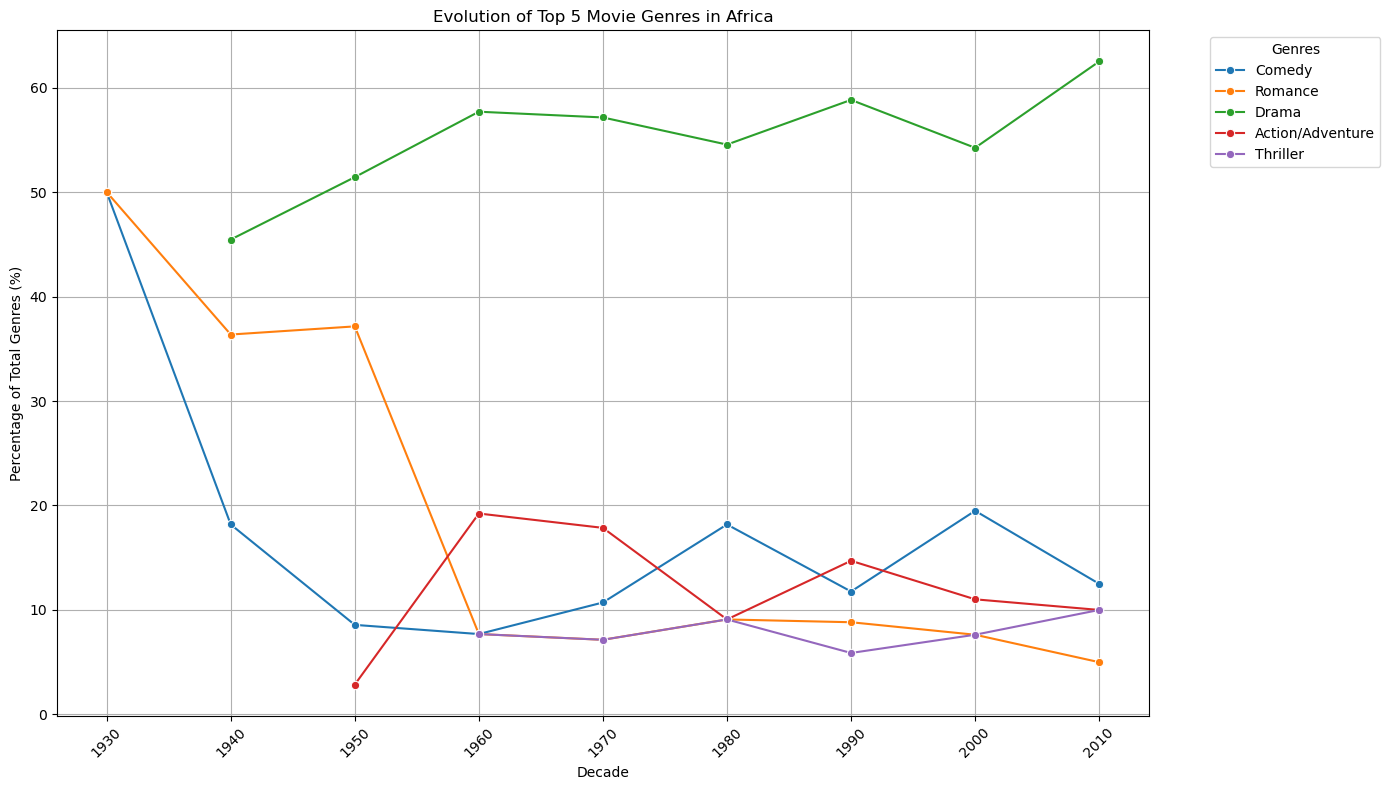

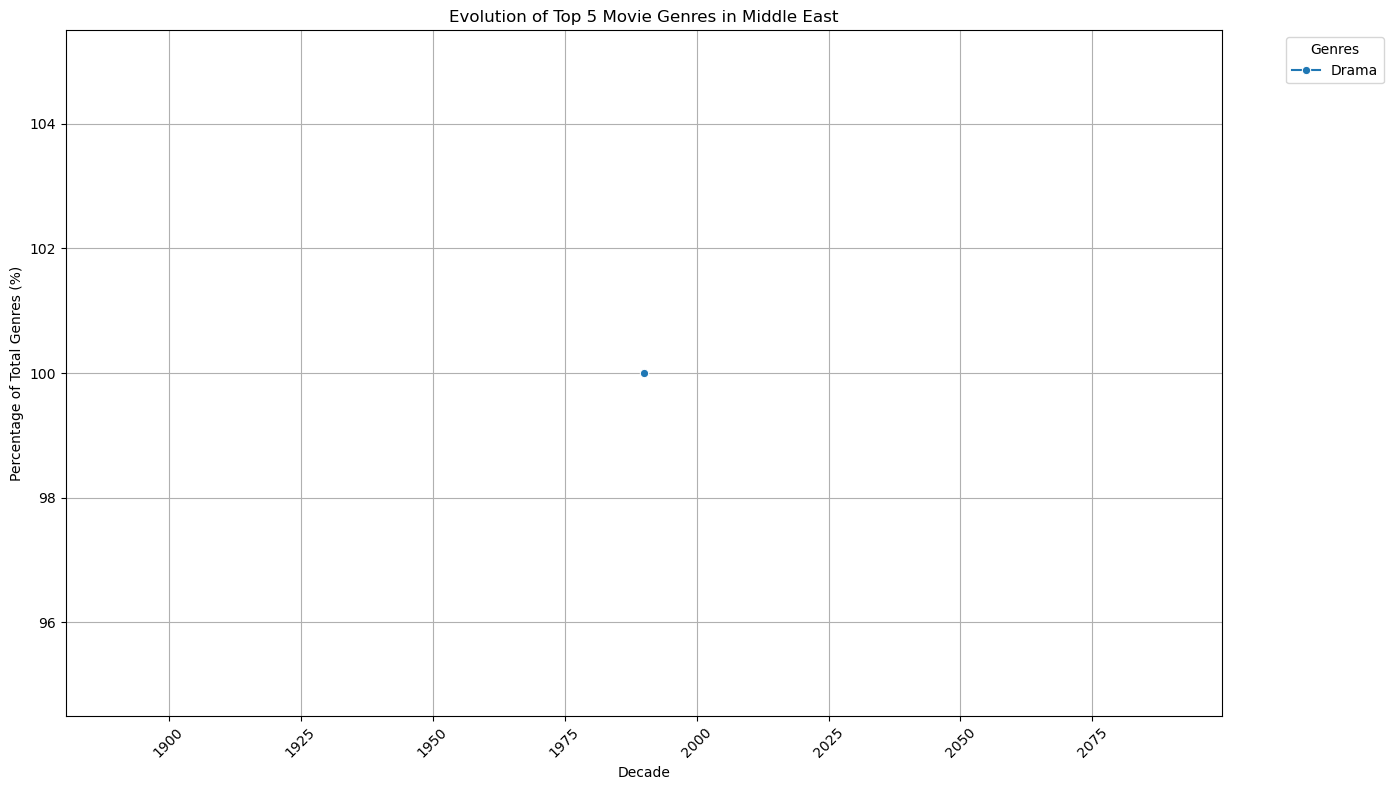

In [53]:
# Evolution of the overall top 5 genres in each continent
plot_top_genres_by_continent_overall(df_expanded)

### Observations

A really interesting first observation is the significant drop in the percentage of the Comedy genre in Africa, North America and Europe, with the biggest one happening in Europe. We observe that a really big part of movies before 1900 are comedies, but only less than 20% are comedies from the 1910 decade.

Among the overall top five genres, Drama stands out as the dominant genre across all continents, with each producing more Drama movies than any other genre. However, the distribution of the overall top five genres varies considerably between continents: the distribution seems more balanced in North America (every genre in the overall top 5 takes between 10% and 30% of the total number of movies of these genres) compared to Africa, which has more than 50% of their movies in the Drama genre, leaving less than half distributed over the four other genres.

Other genres do not seem to have a strong fluctuation in their distribution across the decades. We just note that Africa also has a strong decline in the Romance genre between 1930 and 1960, to produce more Drama movies. A guess that could explain this trend is the historical background of Africa during these decades (colonization, global conflicts...).

## Conclusion on the movies genres analysis

From the observations of the evolution of movies genres throughout the decades, there seems to be a hint that societal themes and topics are related to the movies.

## Movie theme modeling

Lastly, we used another NLP model to try to extract information about the theme of the movies, which does not have any nkind of tag in the dataset. We think the themes of movie plots could be more usefull for our analysis than movie genre in the dataset. All implementations relative to this part are in the model.py file. 

In [2]:
# Fit the model

# Get data and model
data, meta_data, valid_words = m.get_data()
w2v_model = m.get_model()
# Preprocess the data
data, word2vec = m.w2v_preprocessing(data, valid_words, w2v_model)
# Get the vectorized wordcount data
X_sparse, word_to_index, movie_id_to_index = m.get_vectorized_data(data)
# Get the tf-idf matrix
tf_idf = m.compute_tf_idf(X_sparse)
print(tf_idf.shape)

Number of words in the model:  39291
Number of words not in the model (should be 0 now):  0


/Users/antoine/anaconda3/envs/gensim_env/lib/python3.10/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)


(42303, 39290)


In [3]:
# Get the movie vectors
movie_vectors = m.compute_movie_vectors(tf_idf, w2v_model, word_to_index, movie_id_to_index, data)

In [5]:
# clustering the movies

df_plot = pd.read_csv('data/MovieSummaries/plot_summaries.txt', sep="\t", header=None)
df_plot.columns = ["Movie ID", "Plot_summary"]

kmeans = KMeans(n_clusters=10, random_state=0).fit(movie_vectors)

# Get the 5 movies closest from each cluster center
for i in range(10):
    print("Cluster", i+1)
    # Print the 5 closest words to the cluster center
    print("Closest words : ", [w2v_model.similar_by_vector(kmeans.cluster_centers_[i])[j][0] for j in range(10)])
    # For each cluster, print the movie descriptions to see if the clustering makes sense
    closest_movies_ids = data.iloc[np.argsort(np.linalg.norm(movie_vectors - kmeans.cluster_centers_[i], axis=1))[:5]]["Wikipedia_movie_ID"].values
    for j in range(5):
        print()
        print("Movie :", j, df_plot[df_plot["Movie ID"].isin(closest_movies_ids)]["Plot_summary"].values[j])
        print()

Cluster 1
Closest words :  ['pretending', 'pretend', 'thinks', 'telling', 'knowing', 'two-timing', 'something', 'terrified', 'afraid', 'indeed']

Movie : 0 A colorful family from a small Texas town must come to grips with the accidental death of the elderly family matriarch during a clandestine meeting in a seedy motel room with her much younger, married neighbor. The woman's family must deal with their own demons while preparing for what could be an embarrassing funeral.


Movie : 1 Priya  lost her parents when she was a kid and the will decried that her wealth would go to an orphanage if something happened to her. Ramanathan ( has cleverly positioned himself as an affectionate uncle to his niece Priya and planned to kill her with help of Raja  and Ranjith , a couple of petty thieves. Raja naturally falls in love with Priya. And the rest of story is how he protects her from Ramanathan.


Movie : 2 Ajay Sharma is a very successful entrepreneur who has now transformed into a workaholic 

Overall, we see that some cluster are not meaningfull. In particular, cluster 7 is full of movies with no actual descriptions, the plot summary is nothing but a list of the characters and the actors. This is reflected in the words closest to the cluster center : 'role', 'roles', 'rôle'.

Additionnally, some movies with very short to no descriptions appear near multiple cluster centers. This could indicate that a large part of the movies have very short to no description, and are thus forming a large cluster near the origin, while the remaining movies are dispersed in a vector space too large to be able to form actual clusters. 

This could be solved with an additionnal preprocessing step that ignores movies without a plot description, or by using another way of extraction meaning from our movie vectors that does not rely on clustering, such as a querry mechanism. We will investigate these options for Milestone 3.